In [1]:
import pandas as pd
from datetime import datetime, timedelta

# Load the CSV file
file_path = "dataForTests.csv"
df = pd.read_csv(file_path)

# List of columns to keep
columns_to_keep = [
    "File Start Date", "File End Date", "File Start Time", "File End Time", 
    "File Duration", "Hectometer Head", "Hectometer Tail", "Route Letter", 
    "Route Number", "Route Description", "Hectometering Direction", 
    "Head Road Section From", "Head Road Section To", "Trajectory From", "Trajectory To"
]

# Drop all other columns except the ones listed above
df_filtered = df[columns_to_keep]

# Display the first few rows of the filtered dataframe
df_filtered.head()

/tmp/ipykernel_18977/148216218.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


,File Start Date,File End Date,File Start Time,File End Time,File Duration,Hectometer Head,Hectometer Tail,Route Letter,Route Number,Route Description,Hectometering Direction,Head Road Section From,Head Road Section To,Trajectory From,Trajectory To
0,2022-04-04,2022-04-04,08:02:29,08:09:00,6.517,21.7,25.4,A,4,A4,descending,Roelofarendsveen,Ringvaart-Aquaduct,Den Haag,Amsterdam
1,2022-04-04,2022-04-04,08:02:29,08:10:02,7.550,26.8,29.3,A,4,A4,descending,Hoogmade,Roelofarendsveen,Den Haag,Amsterdam
2,2022-04-04,2022-04-04,08:03:30,08:06:00,2.500,53.0,56.2,A,16,A16,descending,Zonzeel,Zevenbergschen Hoek,Breda,Rotterdam
3,2022-04-04,2022-04-04,08:03:30,08:07:00,3.500,31.0,32.9,A,27,A27,descending,Werkendam,Nieuwendijk,Gorinchem,Breda
4,2022-04-04,2022-04-04,08:03:30,08:42:03,38.550,0.0,2.3,A,44,A44,descending,Nieuw-Vennep,Burgerveen,Wassenaar,Amsterdam


In [2]:
# Create a copy of the filtered DataFrame to avoid SettingWithCopyWarning
df_filtered_copy = df_filtered.copy()

# Converting time columns to datetime for easier filtering
df_filtered_copy['File Start Time'] = pd.to_datetime(df_filtered_copy['File Start Time'], format='%H:%M:%S').dt.time
df_filtered_copy['File End Time'] = pd.to_datetime(df_filtered_copy['File End Time'], format='%H:%M:%S').dt.time

# Adding a new column to check if the start hour is different from the end hour
df_filtered_copy['Different Start-End Hour'] = df_filtered_copy['File Start Time'].apply(lambda x: x.hour) != df_filtered_copy['File End Time'].apply(lambda x: x.hour)

pd.set_option('display.max_rows', 10)
df_filtered_copy.head(10)



,File Start Date,File End Date,File Start Time,File End Time,File Duration,Hectometer Head,Hectometer Tail,Route Letter,Route Number,Route Description,Hectometering Direction,Head Road Section From,Head Road Section To,Trajectory From,Trajectory To,Different Start-End Hour
0,2022-04-04,2022-04-04,08:02:29,08:09:00,6.517,21.7,25.4,A,4,A4,descending,Roelofarendsveen,Ringvaart-Aquaduct,Den Haag,Amsterdam,False
1,2022-04-04,2022-04-04,08:02:29,08:10:02,7.550,26.8,29.3,A,4,A4,descending,Hoogmade,Roelofarendsveen,Den Haag,Amsterdam,False
2,2022-04-04,2022-04-04,08:03:30,08:06:00,2.500,53.0,56.2,A,16,A16,descending,Zonzeel,Zevenbergschen Hoek,Breda,Rotterdam,False
3,2022-04-04,2022-04-04,08:03:30,08:07:00,3.500,31.0,32.9,A,27,A27,descending,Werkendam,Nieuwendijk,Gorinchem,Breda,False
4,2022-04-04,2022-04-04,08:03:30,08:42:03,38.550,0.0,2.3,A,44,A44,descending,Nieuw-Vennep,Burgerveen,Wassenaar,Amsterdam,False
5,2022-04-04,2022-04-04,08:20:30,08:25:01,4.517,41.5,44.2,A,2,A2,descending,Vinkeveen,Abcoude,Utrecht,Amsterdam,False
6,2022-04-04,2022-04-04,08:20:30,08:58:00,37.500,79.6,83.0,A,27,A27,descending,De Bilt,Rijnsweerd,Utrecht,Gorinchem,False
7,2022-04-04,2022-04-04,08:20:30,08:22:00,1.500,19.1,21.1,A,58,A58,descending,Oirschot,Best,Tilburg,Eindhoven,False
8,2022-04-04,2022-04-04,08:20:30,08:51:01,30.517,159.4,161.4,N,2,N2,descending,Eindhoven-Centrum,Eindhoven-Airport,Leenderheide,Batadorp,False
9,2022-04-04,2022-04-04,08:21:30,09:01:01,39.517,52.3,54.3,A,15,A15,descending,Rotterdam-Heijplaat,Benelux,Ridderkerk,Europoort,True


In [3]:
df_filtered_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   File Start Date           99999 non-null  object 
 1   File End Date             99999 non-null  object 
 2   File Start Time           99999 non-null  object 
 3   File End Time             99999 non-null  object 
 4   File Duration             99999 non-null  float64
 5   Hectometer Head           99999 non-null  float64
 6   Hectometer Tail           99999 non-null  float64
 7   Route Letter              99999 non-null  object 
 8   Route Number              99999 non-null  int64  
 9   Route Description         99999 non-null  object 
 10  Hectometering Direction   99999 non-null  object 
 11  Head Road Section From    99999 non-null  object 
 12  Head Road Section To      99999 non-null  object 
 13  Trajectory From           99999 non-null  object 
 14  Trajec

In [4]:

from datetime import datetime, timedelta
import numpy as np

def calculate_absolute_hectometer_per_minute(row):
    """
    Calculate the absolute value of hectometers per minute for a given row.
    """
    start_datetime = datetime.strptime(f"{row['File Start Date']} {row['File Start Time']}", '%Y-%m-%d %H:%M:%S')
    end_datetime = datetime.strptime(f"{row['File End Date']} {row['File End Time']}", '%Y-%m-%d %H:%M:%S')
    total_minutes = (end_datetime - start_datetime).total_seconds() / 60
    hectometer_distance = abs(row['Hectometer Tail'] - row['Hectometer Head'])
    return hectometer_distance / total_minutes if total_minutes > 0 else 0

def split_rows_with_absolute_hpm(data):
    """
    Split rows based on different hours in 'File Start Time' and 'File End Time'
    and also consider different dates. The split will end at XX:59:59. 
    'Hectometer per Minute' is calculated as an absolute value.
    """
    new_data = []
    for index, row in data.iterrows():
        start_date_str = str(row['File Start Date'])
        end_date_str = str(row['File End Date'])
        start_time_str = str(row['File Start Time'])
        end_time_str = str(row['File End Time'])

        start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
        end_date = datetime.strptime(end_date_str, '%Y-%m-%d')
        start_time = datetime.strptime(start_time_str, '%H:%M:%S')
        end_time = datetime.strptime(end_time_str, '%H:%M:%S')

        hpm = calculate_absolute_hectometer_per_minute(row)

        start_dt = datetime.combine(start_date, start_time.time())
        end_dt = datetime.combine(end_date, end_time.time())

        while start_dt < end_dt:
            new_row = row.copy()
            new_row['File Start Date'] = start_dt.strftime('%Y-%m-%d')
            new_row['File Start Time'] = start_dt.strftime('%H:%M:%S')

            next_hour = (start_dt.replace(minute=0, second=0, microsecond=0) + timedelta(hours=1)) - timedelta(seconds=1)
            segment_end_dt = min(next_hour, end_dt)

            new_row['File End Date'] = segment_end_dt.strftime('%Y-%m-%d')
            new_row['File End Time'] = segment_end_dt.strftime('%H:%M:%S')

            time_span = (segment_end_dt - start_dt).total_seconds() / 60
            hectometer_span = time_span * hpm
            new_row['Hectometer Tail'] = row['Hectometer Head'] + hectometer_span
            new_row['Hectometer per Minute'] = hpm

            new_data.append(new_row)

            start_dt = segment_end_dt + timedelta(seconds=1)
            row['Hectometer Head'] = new_row['Hectometer Tail']

    return pd.DataFrame(new_data)

# Applying the function with absolute hectometer per minute to the dataset
split_data_with_absolute_hpm = split_rows_with_absolute_hpm(df_filtered_copy)  # Testing with a smaller subset

data_df = split_data_with_absolute_hpm
# Adding sorting by 'File Duration' in descending order at the end of the process
pd.set_option('display.max_rows', 100)
# Display the first few rows of the sorted DataFrame for debugging purposes
data_df.head(100)




,File Start Date,File End Date,File Start Time,File End Time,File Duration,Hectometer Head,Hectometer Tail,Route Letter,Route Number,Route Description,Hectometering Direction,Head Road Section From,Head Road Section To,Trajectory From,Trajectory To,Different Start-End Hour,Hectometer per Minute
0,2022-04-04,2022-04-04,08:02:29,08:09:00,6.517,21.700000,25.400000,A,4,A4,descending,Roelofarendsveen,Ringvaart-Aquaduct,Den Haag,Amsterdam,False,0.567775
1,2022-04-04,2022-04-04,08:02:29,08:10:02,7.550,26.800000,29.300000,A,4,A4,descending,Hoogmade,Roelofarendsveen,Den Haag,Amsterdam,False,0.331126
2,2022-04-04,2022-04-04,08:03:30,08:06:00,2.500,53.000000,56.200000,A,16,A16,descending,Zonzeel,Zevenbergschen Hoek,Breda,Rotterdam,False,1.280000
3,2022-04-04,2022-04-04,08:03:30,08:07:00,3.500,31.000000,32.900000,A,27,A27,descending,Werkendam,Nieuwendijk,Gorinchem,Breda,False,0.542857
4,2022-04-04,2022-04-04,08:03:30,08:42:03,38.550,0.000000,2.300000,A,44,A44,descending,Nieuw-Vennep,Burgerveen,Wassenaar,Amsterdam,False,0.059663
5,2022-04-04,2022-04-04,08:20:30,08:25:01,4.517,41.500000,44.200000,A,2,A2,descending,Vinkeveen,Abcoude,Utrecht,Amsterdam,False,0.597786
6,2022-04-04,2022-04-04,08:20:30,08:58:00,37.500,79.600000,83.000000,A,27,A27,descending,De Bilt,Rijnsweerd,Utrecht,Gorinchem,False,0.090667
7,2022-04-04,2022-04-04,08:20:30,08:22:00,1.500,19.100000,21.100000,A,58,A58,descending,Oirschot,Best,Tilburg,Eindhoven,False,1.333333
8,2022-04-04,2022-04-04,08:20:30,08:51:01,30.517,159.400000,161.400000,N,2,N2,descending,Eindhoven-Centrum,Eindhoven-Airport,Leenderheide,Batadorp,False,0.065538
9,2022-04-04,2022-04-04,08:21:30,08:59:59,39.517,52.300000,54.247701,A,15,A15,descending,Rotterdam-Heijplaat,Benelux,Ridderkerk,Europoort,True,0.050612


In [5]:
# Convert 'File Start Time' and 'File End Time' to datetime
data_df['File Start Time'] = pd.to_datetime(data_df['File Start Time'], format='%H:%M:%S')
data_df['File End Time'] = pd.to_datetime(data_df['File End Time'], format='%H:%M:%S')

# Adding a dummy date to the time fields
dummy_date = datetime(2000, 1, 1)  # The date doesn't matter, it's just a placeholder

# Convert time to string and concatenate with dummy date
data_df['start_datetime_full'] = pd.to_datetime(
    dummy_date.strftime('%Y-%m-%d') + ' ' + data_df['File Start Time'].dt.strftime('%H:%M:%S')
)
data_df['end_datetime_full'] = pd.to_datetime(
    dummy_date.strftime('%Y-%m-%d') + ' ' + data_df['File End Time'].dt.strftime('%H:%M:%S')
)

# Calculate the time difference
data_df['time_difference'] = data_df['end_datetime_full'] - data_df['start_datetime_full']

# Convert time difference to total seconds
data_df['time_difference_seconds'] = data_df['time_difference'].dt.total_seconds()

# Convert time difference to total minutes
data_df['time_difference_minutes'] = data_df['time_difference_seconds'] / 60

# Remove the dummy date, keeping only the time
data_df['start_time'] = data_df['start_datetime_full'].dt.time
data_df['end_time'] = data_df['end_datetime_full'].dt.time

# Display the DataFrame
pd.set_option('display.max_rows', 10)
data_df.head(10)

,File Start Date,File End Date,File Start Time,File End Time,File Duration,Hectometer Head,Hectometer Tail,Route Letter,Route Number,Route Description,...,Trajectory To,Different Start-End Hour,Hectometer per Minute,start_datetime_full,end_datetime_full,time_difference,time_difference_seconds,time_difference_minutes,start_time,end_time
0,2022-04-04,2022-04-04,1900-01-01 08:02:29,1900-01-01 08:09:00,6.517,21.7,25.400000,A,4,A4,...,Amsterdam,False,0.567775,2000-01-01 08:02:29,2000-01-01 08:09:00,0 days 00:06:31,391.0,6.516667,08:02:29,08:09:00
1,2022-04-04,2022-04-04,1900-01-01 08:02:29,1900-01-01 08:10:02,7.550,26.8,29.300000,A,4,A4,...,Amsterdam,False,0.331126,2000-01-01 08:02:29,2000-01-01 08:10:02,0 days 00:07:33,453.0,7.550000,08:02:29,08:10:02
2,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:06:00,2.500,53.0,56.200000,A,16,A16,...,Rotterdam,False,1.280000,2000-01-01 08:03:30,2000-01-01 08:06:00,0 days 00:02:30,150.0,2.500000,08:03:30,08:06:00
3,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:07:00,3.500,31.0,32.900000,A,27,A27,...,Breda,False,0.542857,2000-01-01 08:03:30,2000-01-01 08:07:00,0 days 00:03:30,210.0,3.500000,08:03:30,08:07:00
4,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:42:03,38.550,0.0,2.300000,A,44,A44,...,Amsterdam,False,0.059663,2000-01-01 08:03:30,2000-01-01 08:42:03,0 days 00:38:33,2313.0,38.550000,08:03:30,08:42:03
5,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:25:01,4.517,41.5,44.200000,A,2,A2,...,Amsterdam,False,0.597786,2000-01-01 08:20:30,2000-01-01 08:25:01,0 days 00:04:31,271.0,4.516667,08:20:30,08:25:01
6,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:58:00,37.500,79.6,83.000000,A,27,A27,...,Gorinchem,False,0.090667,2000-01-01 08:20:30,2000-01-01 08:58:00,0 days 00:37:30,2250.0,37.500000,08:20:30,08:58:00
7,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:22:00,1.500,19.1,21.100000,A,58,A58,...,Eindhoven,False,1.333333,2000-01-01 08:20:30,2000-01-01 08:22:00,0 days 00:01:30,90.0,1.500000,08:20:30,08:22:00
8,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:51:01,30.517,159.4,161.400000,N,2,N2,...,Batadorp,False,0.065538,2000-01-01 08:20:30,2000-01-01 08:51:01,0 days 00:30:31,1831.0,30.516667,08:20:30,08:51:01
9,2022-04-04,2022-04-04,1900-01-01 08:21:30,1900-01-01 08:59:59,39.517,52.3,54.247701,A,15,A15,...,Europoort,True,0.050612,2000-01-01 08:21:30,2000-01-01 08:59:59,0 days 00:38:29,2309.0,38.483333,08:21:30,08:59:59


In [6]:
data_df.to_csv('forGPT.csv', index=False)

In [7]:
# Function to generate time ranges (e.g., 07:00 - 08:00)
def generate_time_ranges(start_hour, end_hour):
    ranges = []
    for hour in range(start_hour, end_hour):
        start_time = datetime.strptime(f"{hour:02d}:00", "%H:%M")
        end_time = start_time + timedelta(hours=1)
        ranges.append((start_time.time(), end_time.time()))
    return ranges
 
# Generate time ranges from 00:00 to 23:00
time_ranges = generate_time_ranges(0, 24)
 
# Function to assign a time range to a datetime
def assign_time_range(dt, time_ranges):
    for start, end in time_ranges:
        if start <= dt.time() < end:
            return f"{start.strftime('%H:%M')} - {end.strftime('%H:%M')}"
    return None
 
# Assigning time ranges to each record
data_df['Time Period'] = data_df['File Start Time'].apply(lambda dt: assign_time_range(dt, time_ranges))

# Calculate the delay per hectometer
data_df['HM Difference'] = data_df['Hectometer Tail'] - data_df['Hectometer Head']
data_df['Time Difference'] = (data_df['File End Time'] - data_df['File Start Time']).dt.total_seconds() / 60  # in minutes
data_df['Min. per HM'] = data_df['Time Difference'] / data_df['HM Difference']
 
# Function to split the data for every 0.1 HM increment
def split_hm_sections(row):
    hm_start = row['Hectometer Head']
    hm_end = row['Hectometer Tail']
    hm_sections = []
 
    # Generate 0.1 HM increments within the range
    while hm_start < hm_end:
        next_hm = min(hm_start + 0.1, hm_end)
        hm_sections.append({
            'Date': row['File Start Date'],
            'Time Period': row['Time Period'],
            'HM Section': round(hm_start, 1),
            'Min. per HM': row['Min. per HM'] * (next_hm - hm_start)
        })
        hm_start = next_hm
 
    return hm_sections
 


# Apply the function to each row and create a new DataFrame
split_data = pd.DataFrame([item for _, row in data_df.iterrows() for item in split_hm_sections(row)])


 
# Display the first few rows of the transformed dataset
pd.set_option('display.max_rows', 100)
data_df.head(100)



,File Start Date,File End Date,File Start Time,File End Time,File Duration,Hectometer Head,Hectometer Tail,Route Letter,Route Number,Route Description,...,end_datetime_full,time_difference,time_difference_seconds,time_difference_minutes,start_time,end_time,Time Period,HM Difference,Time Difference,Min. per HM
0,2022-04-04,2022-04-04,1900-01-01 08:02:29,1900-01-01 08:09:00,6.517,21.700000,25.400000,A,4,A4,...,2000-01-01 08:09:00,0 days 00:06:31,391.0,6.516667,08:02:29,08:09:00,08:00 - 09:00,3.700000,6.516667,1.761261
1,2022-04-04,2022-04-04,1900-01-01 08:02:29,1900-01-01 08:10:02,7.550,26.800000,29.300000,A,4,A4,...,2000-01-01 08:10:02,0 days 00:07:33,453.0,7.550000,08:02:29,08:10:02,08:00 - 09:00,2.500000,7.550000,3.020000
2,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:06:00,2.500,53.000000,56.200000,A,16,A16,...,2000-01-01 08:06:00,0 days 00:02:30,150.0,2.500000,08:03:30,08:06:00,08:00 - 09:00,3.200000,2.500000,0.781250
3,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:07:00,3.500,31.000000,32.900000,A,27,A27,...,2000-01-01 08:07:00,0 days 00:03:30,210.0,3.500000,08:03:30,08:07:00,08:00 - 09:00,1.900000,3.500000,1.842105
4,2022-04-04,2022-04-04,1900-01-01 08:03:30,1900-01-01 08:42:03,38.550,0.000000,2.300000,A,44,A44,...,2000-01-01 08:42:03,0 days 00:38:33,2313.0,38.550000,08:03:30,08:42:03,08:00 - 09:00,2.300000,38.550000,16.760870
5,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:25:01,4.517,41.500000,44.200000,A,2,A2,...,2000-01-01 08:25:01,0 days 00:04:31,271.0,4.516667,08:20:30,08:25:01,08:00 - 09:00,2.700000,4.516667,1.672840
6,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:58:00,37.500,79.600000,83.000000,A,27,A27,...,2000-01-01 08:58:00,0 days 00:37:30,2250.0,37.500000,08:20:30,08:58:00,08:00 - 09:00,3.400000,37.500000,11.029412
7,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:22:00,1.500,19.100000,21.100000,A,58,A58,...,2000-01-01 08:22:00,0 days 00:01:30,90.0,1.500000,08:20:30,08:22:00,08:00 - 09:00,2.000000,1.500000,0.750000
8,2022-04-04,2022-04-04,1900-01-01 08:20:30,1900-01-01 08:51:01,30.517,159.400000,161.400000,N,2,N2,...,2000-01-01 08:51:01,0 days 00:30:31,1831.0,30.516667,08:20:30,08:51:01,08:00 - 09:00,2.000000,30.516667,15.258333
9,2022-04-04,2022-04-04,1900-01-01 08:21:30,1900-01-01 08:59:59,39.517,52.300000,54.247701,A,15,A15,...,2000-01-01 08:59:59,0 days 00:38:29,2309.0,38.483333,08:21:30,08:59:59,08:00 - 09:00,1.947701,38.483333,19.758333


In [8]:
# Grouping the data by 'Time Period' and 'File Start Date' and summing the 'Time Difference Minutes'
grouped_data = data_df.groupby(['Time Period', 'File Start Date'])['time_difference_minutes'].sum().reset_index()

# Renaming the column for clarity
grouped_data.rename(columns={'time_difference_minutes': 'Total Time Difference (Minutes)'}, inplace=True)

grouped_data.to_csv('nonTimeSort.csv', index=False)
pd.set_option('display.max_rows', 100)
grouped_data.head(100)


,Time Period,File Start Date,Total Time Difference (Minutes)
0,00:00 - 01:00,2022-02-05,41.000000
1,00:00 - 01:00,2022-02-21,2.000000
2,00:00 - 01:00,2022-02-27,0.316667
3,00:00 - 01:00,2022-04-02,10.233333
4,00:00 - 01:00,2022-04-05,1.516667
5,00:00 - 01:00,2022-04-06,5.050000
6,00:00 - 01:00,2022-04-08,7.683333
7,00:00 - 01:00,2022-04-10,21.066667
8,00:00 - 01:00,2022-04-12,15.700000
9,00:00 - 01:00,2022-04-26,21.366667


In [12]:
import re

# Function to convert time period and date into a single datetime object
def convert_to_datetime(date_str, time_period):
    start_hour = int(time_period.split(':')[0])
    datetime_str = f"{date_str} {start_hour:02d}:00"
    return datetime.strptime(datetime_str, '%Y-%m-%d %H:%M')

# Applying the function to each row
grouped_data['Datetime'] = grouped_data.apply(lambda row: convert_to_datetime(row['File Start Date'], row['Time Period']), axis=1)

# Sorting the data by the new datetime column
sorted_data = grouped_data.sort_values(by='Datetime')

# Displaying the sorted data
pd.set_option('display.max_rows', 100)
sorted_data.head(100)

,Time Period,File Start Date,Total Time Difference (Minutes),Datetime,Date and Time Period
977,12:00 - 13:00,2022-01-02,42.450000,2022-01-02 12:00:00,2022-01-02 - 12:00 - 13:00
1319,14:00 - 15:00,2022-01-02,14.450000,2022-01-02 14:00:00,2022-01-02 - 14:00 - 15:00
1491,15:00 - 16:00,2022-01-02,16.416667,2022-01-02 15:00:00,2022-01-02 - 15:00 - 16:00
1666,16:00 - 17:00,2022-01-02,59.983333,2022-01-02 16:00:00,2022-01-02 - 16:00 - 17:00
1841,17:00 - 18:00,2022-01-02,59.983333,2022-01-02 17:00:00,2022-01-02 - 17:00 - 18:00
2012,18:00 - 19:00,2022-01-02,12.450000,2022-01-02 18:00:00,2022-01-02 - 18:00 - 19:00
122,06:00 - 07:00,2022-01-03,7.450000,2022-01-03 06:00:00,2022-01-03 - 06:00 - 07:00
234,07:00 - 08:00,2022-01-03,44.916667,2022-01-03 07:00:00,2022-01-03 - 07:00 - 08:00
360,08:00 - 09:00,2022-01-03,19.700000,2022-01-03 08:00:00,2022-01-03 - 08:00 - 09:00
642,10:00 - 11:00,2022-01-03,34.350000,2022-01-03 10:00:00,2022-01-03 - 10:00 - 11:00


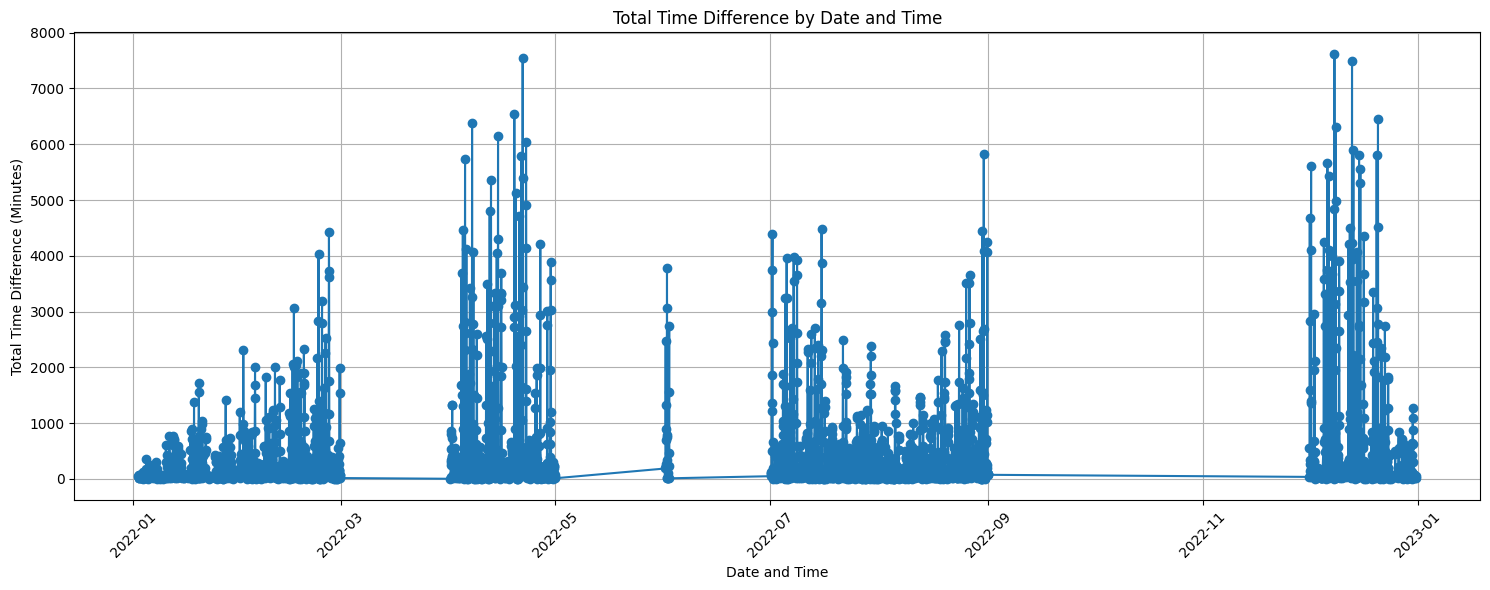

In [13]:
# Plotting the data
plt.figure(figsize=(15, 6))
plt.plot(sorted_data['Datetime'].head(100), sorted_data['Total Time Difference (Minutes)'], marker='o', linestyle='-')
plt.title('Total Time Difference by Date and Time')
plt.xlabel('Date and Time')
plt.ylabel('Total Time Difference (Minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()